In [81]:
import akshare as ak 

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
[f.name for f in fm.fontManager.ttflist if "PingFang" in f.name or "Heiti" in f.name]
plt.rcParams['font.sans-serif'] = ['Heiti TC']

import os 
from datetime import datetime
from tqdm import tqdm

### load the stock codes and symbols

In [65]:
# load hs300 stock list
hs = pd.read_csv('../data/input/hs300_list_20251213.csv')
hs['code'] = hs['code'].astype(str).str.zfill(6)

hs_stocks = hs['code'].tolist()
print(len(hs_stocks))

# load the hongli list
hl = pd.read_csv('../data/input/hongli_list_20251213.csv')
hl['code'] = hl['code'].astype(str).str.zfill(6)

hl_stocks = hl['code'].tolist()
print(len(hl_stocks))

# load the honglidbo stock list
hldb = pd.read_csv('../data/input/honglidibo_list_20251213.csv')
hldb['code'] = hldb['code'].astype(str).str.zfill(6)

hldb_stocks = hldb['code'].tolist()
print(len(hldb_stocks))

# my portfolio
portfolio_stocks = ["600519", "000858", "600938", "000333", "601088", "300866", "600900", "600036", "300750", "601899", "603993"]
print(len(portfolio_stocks))

# convert stock to symbols
hs_symbols = [f"sh{code}" if code.startswith("6") 
                else f"bj{code}" if code.startswith("9")
                else f"sz{code}"
                for code in hs_stocks]
hl_symbols = [f"sh{code}" if code.startswith("6") 
                else f"bj{code}" if code.startswith("9") 
                else f"sz{code}"
                for code in hl_stocks]
hldb_symbols = [f"sh{code}" if code.startswith("6")
                else f"bj{code}" if code.startswith("9") 
                else f"sz{code}"
                for code in hldb_stocks]
portfolio_symbols = [f"sh{code}" if code.startswith("6")
                else f"bj{code}" if code.startswith("9") 
                else f"sz{code}"
                for code in portfolio_stocks]

300
100
50
11


### calculate valuation

In [22]:
today = datetime.today().strftime('%Y%m%d')

# for stock_code, stock_symbol in tqdm(zip(hs_stocks, hs_symbols)):
# for stock_code, stock_symbol in tqdm(zip(hl_stocks, hl_symbols)):
for stock_code, stock_symbol in tqdm(zip(hldb_stocks, hldb_symbols)):
    try:
        financial_date = pd.read_csv(f"../data/input/financial-indicators/20251213/financial_indicators_{stock_code}_20251213.csv")
    except Exception:
        financial_date = pd.read_csv(f"../data/input/financial-indicators/20251213/financial_indicators_{stock_code}_20251214.csv")
        
    try:
        price_df = pd.read_csv(f"../data/input/price-data/20251213/price_data_{stock_symbol}_20251213.csv")
    except Exception:
        price_df = pd.read_csv(f"../data/input/price-data/20251213/price_data_{stock_symbol}_20251214.csv")
        
    # --- merge the price data with financial data ---
    financial_date['report_date'] = pd.to_datetime(financial_date['report_date'])
    price_df['report_date'] = pd.to_datetime(price_df['report_date'])
    financial_date['year'] = financial_date['report_date'].dt.year
    financial_date['month'] = financial_date['report_date'].dt.month
    price_df['year'] = price_df['report_date'].dt.year
    price_df['month'] = price_df['report_date'].dt.month
    # aggregate the daily price into monthly price
    price_month = price_df.groupby(['year', 'month']).agg({'open': 'first', 'close': 'last', 
                                                       'high': 'max', 'low': 'min'}).reset_index()
    
    financial_price = pd.merge(price_month, financial_date, on=['year', 'month'], how='left', validate="1:1")
    financial_price = financial_price.ffill()

    # --- calculate pe_ttm, pb_ttm, pr_ttm ---
    financial_price['pe_ttm'] = financial_price['close'] / financial_price['eps_ttm']
    financial_price['pb_ttm'] = financial_price['close'] / financial_price['bps_ttm']
    financial_price['pr_ttm'] = financial_price['pe_ttm'] / financial_price['roe_ttm']
    financial_price['update_date'] = today
    financial_price.to_csv(f"../data/processed/stock-valuation/20251213/stock_valuation_{stock_code}_20251213.csv", index=False)


50it [00:00, 95.26it/s]


### combine etf

In [ ]:
# pe_ttm, pb_ttm, pr_ttm, roe_ttm viusualization

# hushen300
hs_values = []
for stock in hs_stocks:
    value = pd.read_csv(f"../data/processed/stock-valuation/20251213/stock_valuation_{stock}_20251213.csv")
    value['code'] = stock.zfill(6)
    value_current = value.iloc[-1]
    hs_values.append(value_current)

hs_values = pd.DataFrame(hs_values, columns=value.columns)
hs_values = pd.merge(hs_values, hs[['code', 'name', 'domain']], on='code', how='left', validate='1:1')
print(hs_values.shape)
hs_values.to_csv('../data/output/etf/20251213/hs_valuation_20251213.csv', index=False)

# zhongzheng hongli
hl_values = []
for stock in hl_stocks:
    value = pd.read_csv(f"../data/processed/stock-valuation/20251213/stock_valuation_{stock}_20251213.csv")
    value['code'] = stock.zfill(6)
    value_current = value.iloc[-1]
    hldb_values.append(value_current)

hldb_values = pd.DataFrame(hldb_values, columns=value.columns)
hldb_values = pd.merge(hl_values, hl[['code', 'name', 'weight']], on='code', how='left', validate='1:1')
print(hl_values.shape)
hl_values.to_csv('../data/output/etf/20251213/hl_valuation_20251213.csv', index=False)

# zhongzheng hongli dibo
hldb_values = []
for stock in hldb_stocks:
    value = pd.read_csv(f"../data/processed/stock-valuation/20251213/stock_valuation_{stock}_20251213.csv")
    value['code'] = stock.zfill(6)
    value_current = value.iloc[-1]
    hldb_values.append(value_current)

hldb_values = pd.DataFrame(hldb_values, columns=value.columns)
hldb_values = pd.merge(hldb_values, hldb[['code', 'name', 'weight']], on='code', how='left', validate='1:1')
print(hldb_values.shape)
hldb_values.to_csv('../data/output/etf/20251213/hldb_valuation_20251213.csv', index=False)

hldb_values.head()

(300, 20)
(100, 20)
(50, 20)


,year,month,open,close,high,low,report_date,bps,eps,roe,bps_ttm,eps_ttm,roe_ttm,pe_ttm,pb_ttm,pr_ttm,update_date,code,name,weight
0,2025,12,9.93,9.95,10.19,9.66,2025-12-31,9.80,0.20,2.17,9.7150,0.7493,7.29,13.279060,1.024189,1.821545,20251214,001965,招商公路,1.157
1,2025,12,7.36,7.16,7.50,6.97,2025-12-31,1.14,0.11,9.22,1.1775,0.3786,31.04,18.911780,6.080679,0.609271,20251214,002027,分众传媒,2.102
2,2025,12,50.25,48.47,50.38,46.86,2025-12-31,6.91,0.54,8.02,7.4900,2.7440,36.13,17.663994,6.471295,0.488901,20251214,002032,苏泊尔,1.927
3,2025,12,8.29,8.16,8.52,8.16,2025-12-31,4.04,0.05,1.27,4.1525,0.4194,9.98,19.456366,1.965081,1.949536,20251214,002469,三维化学,1.645
4,2025,12,6.61,6.79,7.62,6.60,2025-12-31,4.34,0.07,1.55,4.3800,0.3259,7.30,20.834612,1.550228,2.854056,20251214,002540,亚太科技,2.474


### visualize values

In [66]:
# my portfolio
portfolio_stocks = ["600519", "000858", "600938", "000333", "601088", "300866", "600900", "600036", "300750", "601899", "603993"]
portfolio_stocks = ["600519", "000858", "600938", "000333", "601088", "600900", "600036", "300750", "601899", "603993"]

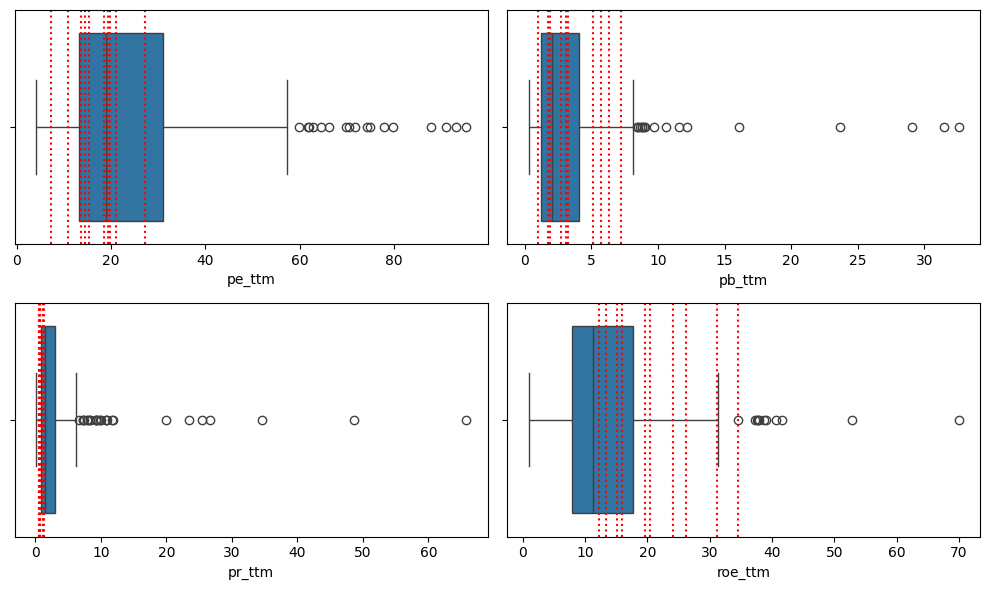

In [72]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes = axes.flatten() 

for i, value in enumerate(['pe_ttm', 'pb_ttm', 'pr_ttm', 'roe_ttm']):
    sns.boxplot(data=hs_values.query("pe_ttm > 0 & pe_ttm < 100"), x=value, ax=axes[i])
    for stock in portfolio_stocks:
        stock_value = hs_values.query(f"code == '{stock}'")[value].values[0]
        axes[i].axvline(stock_value, color='red', linestyle='dotted')
    
plt.tight_layout()
plt.show()

In [101]:
# pe_ttm, pb_ttm, pr_ttm < 25 quantile
# roe_ttm > 25 quantile 
threshold = 0.35
pe_th = hs_values.query("pe_ttm > 0").pe_ttm.quantile(threshold)
pb_th = hs_values.query("pe_ttm > 0").pb_ttm.quantile(threshold)
pr_th = hs_values.query("pe_ttm > 0").pr_ttm.quantile(threshold)
roe_th = hs_values.query("pe_ttm > 0").roe_ttm.quantile(1-threshold)

hs_values_filtered = hs_values.query(f"(pe_ttm < {pe_th}) & (pb_ttm < {pb_th}) & (pr_ttm < {pr_th}) & (roe_ttm > {roe_th})")
hs_values_filtered


,year,month,open,close,high,low,report_date,bps,eps,roe,bps_ttm,eps_ttm,roe_ttm,pe_ttm,pb_ttm,pr_ttm,update_date,code,name,domain
41,2025,12,14.60,14.98,15.12,14.60,2025-12-31,14.99,0.62,4.02,14.9925,2.44,16.15,6.139344,0.999166,0.380145,20251214,601919,中远海控,交通运输
54,2025,12,16.88,16.35,17.30,16.34,2025-12-31,20.01,0.67,3.46,19.5325,3.15,16.05,5.190476,0.837066,0.323394,20251214,601838,成都银行,金融
75,2025,12,34.70,38.24,38.60,34.55,2025-12-31,29.54,1.85,6.20,29.1325,5.44,17.80,7.029412,1.312623,0.394911,20251214,601601,中国太保,金融
83,2025,12,8.65,8.55,8.83,8.08,2025-12-31,7.10,0.46,6.51,6.4800,1.21,18.50,7.066116,1.319444,0.381952,20251214,601319,中国人保,金融
84,2025,12,58.91,63.91,64.09,58.15,2025-12-31,54.47,3.69,6.50,52.2275,7.99,14.40,7.998748,1.223685,0.555469,20251214,601318,中国平安,金融
115,2025,12,15.60,15.12,15.95,15.07,2025-12-31,18.34,0.56,3.18,18.1925,2.76,15.17,5.478261,0.831112,0.361125,20251214,600926,杭州银行,金融
180,2025,12,5.15,5.24,5.33,5.13,2025-12-31,4.19,0.21,5.06,4.1900,0.56,13.66,9.357143,1.250597,0.685003,20251214,600027,华电国际,公用事业
282,2025,12,40.42,40.75,41.17,40.15,2025-12-31,25.78,1.26,5.07,25.0100,5.71,22.78,7.136602,1.629348,0.313284,20251214,000651,格力电器,家电


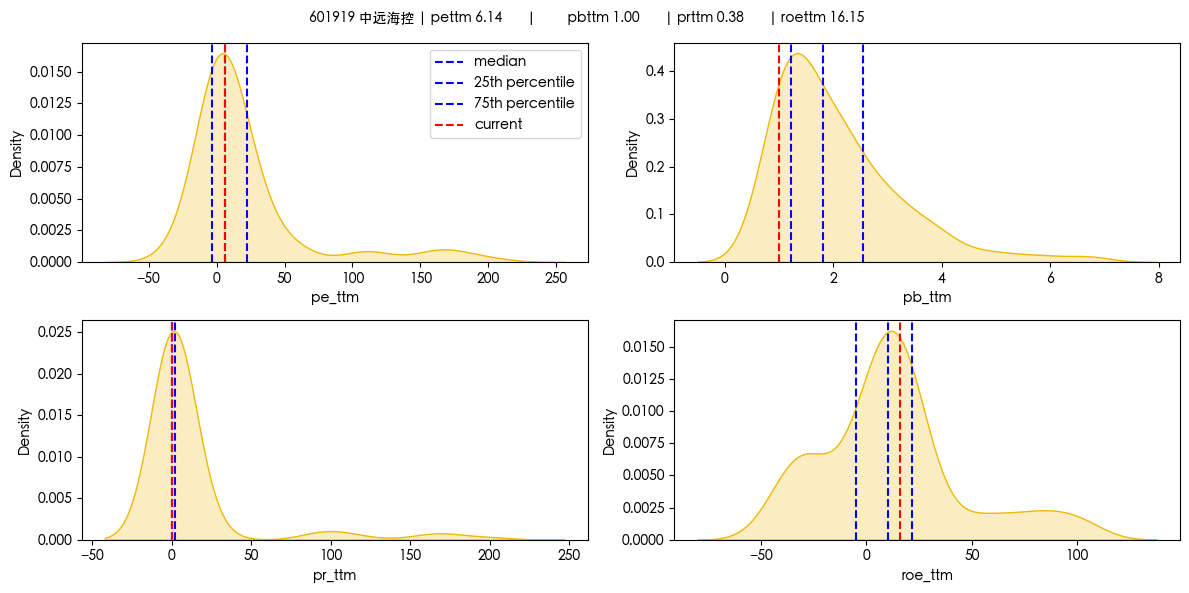

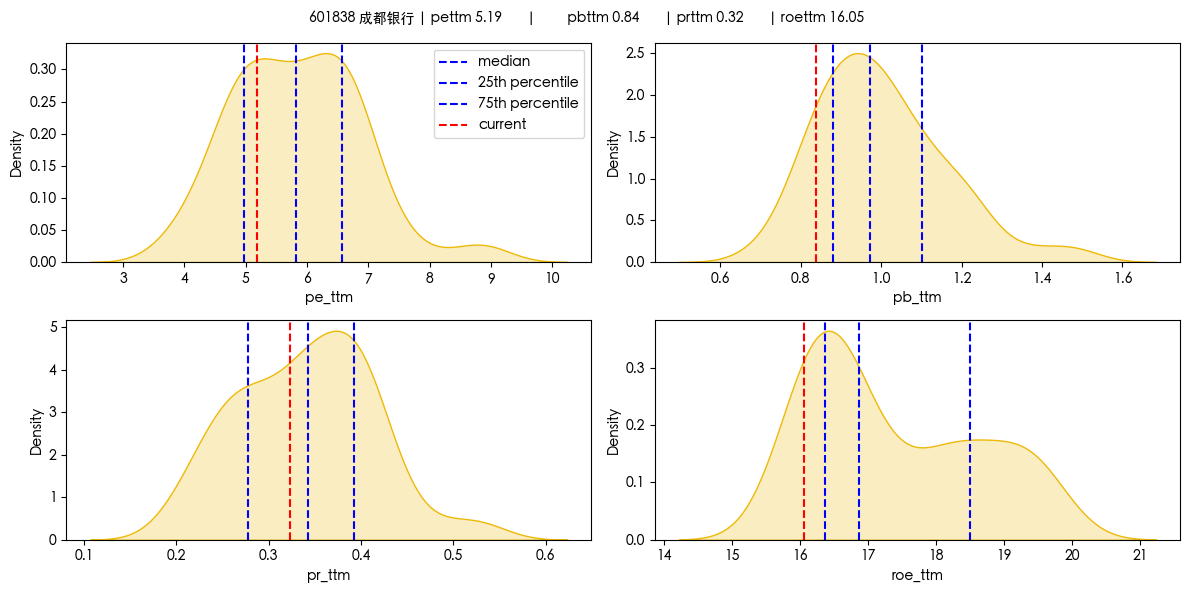

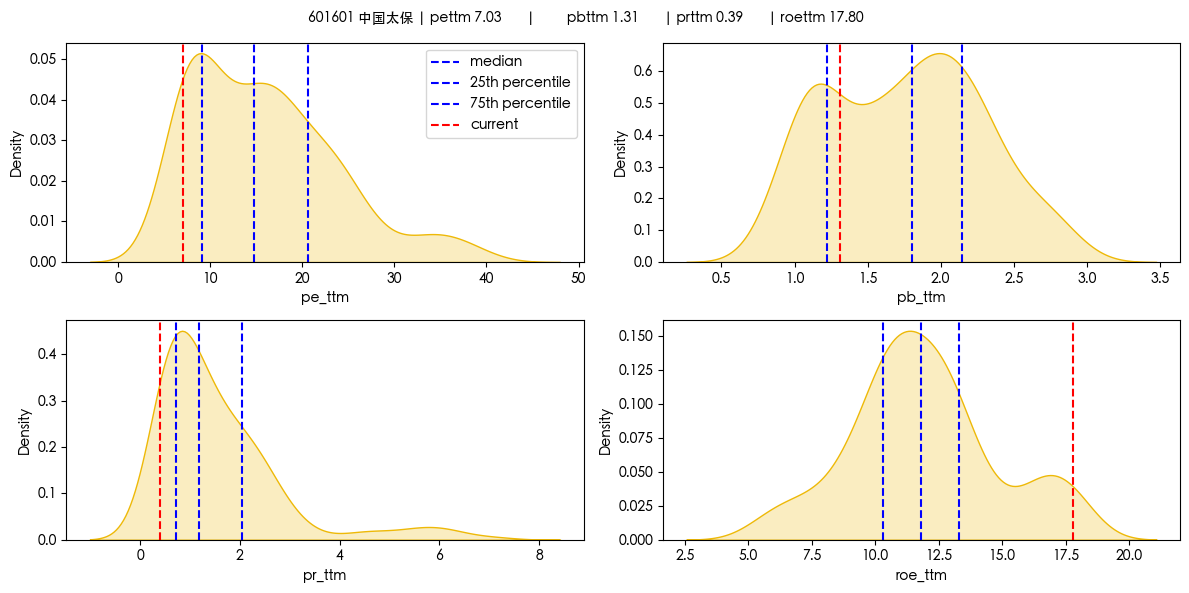

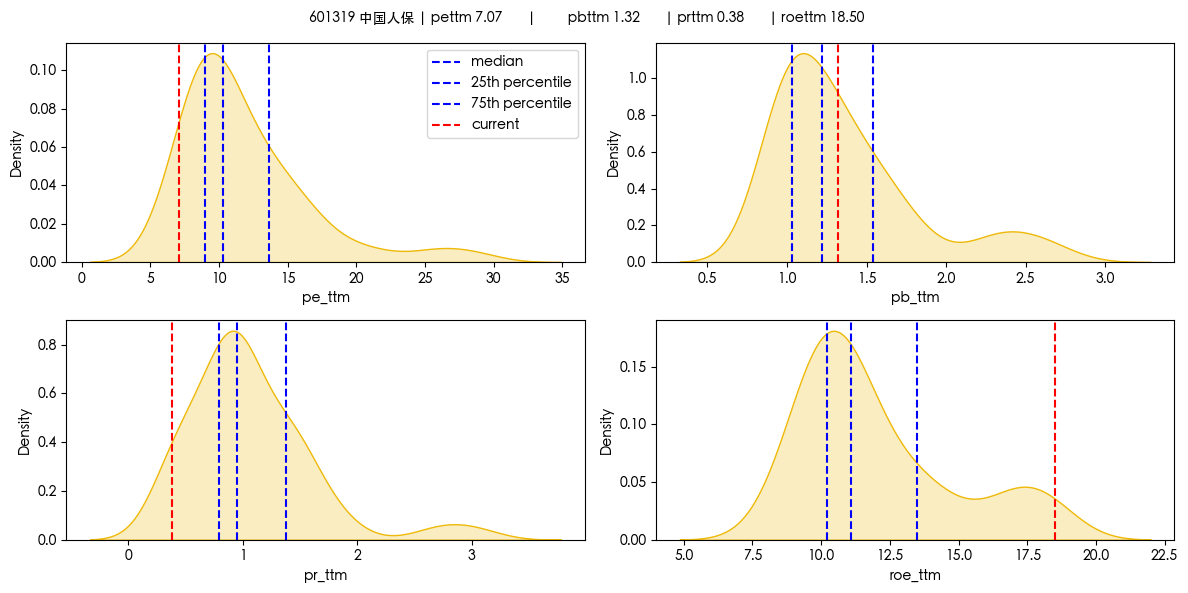

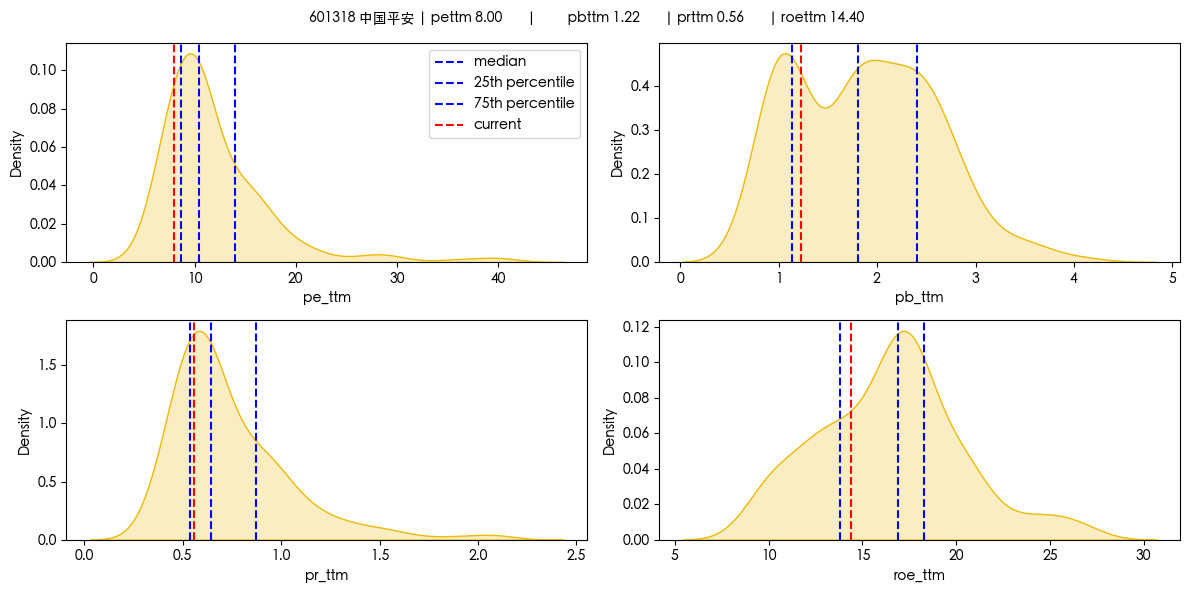

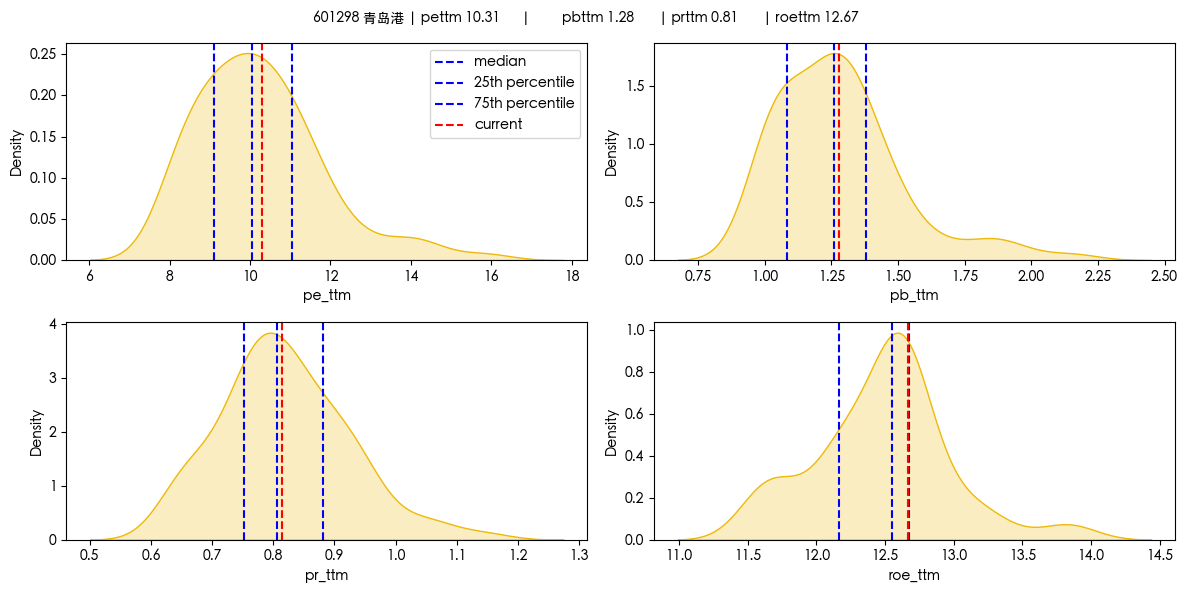

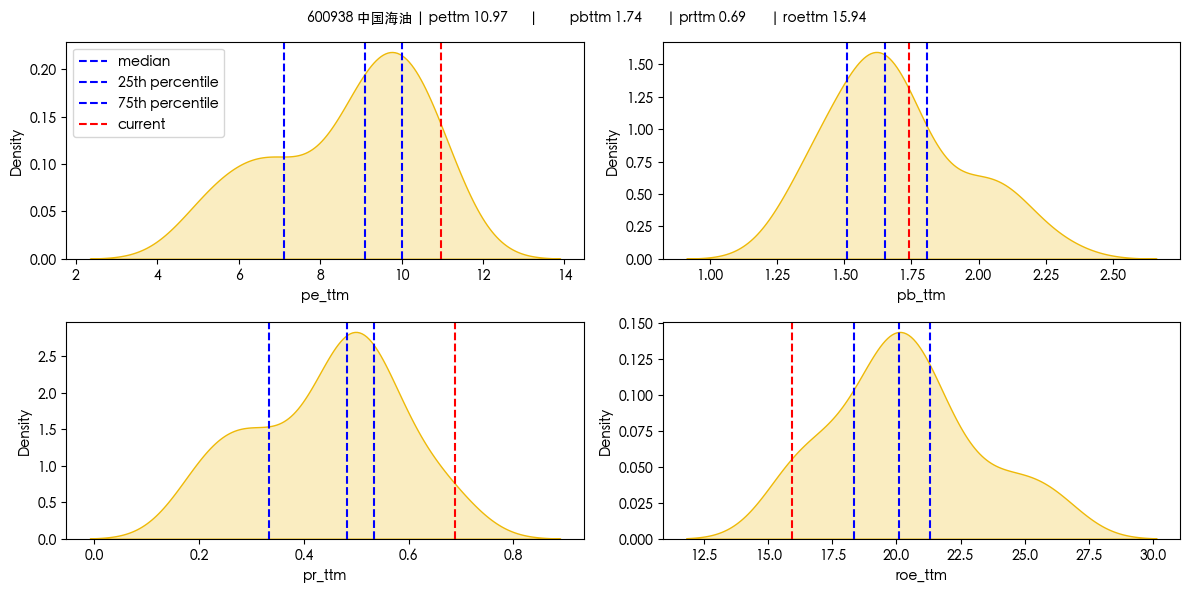

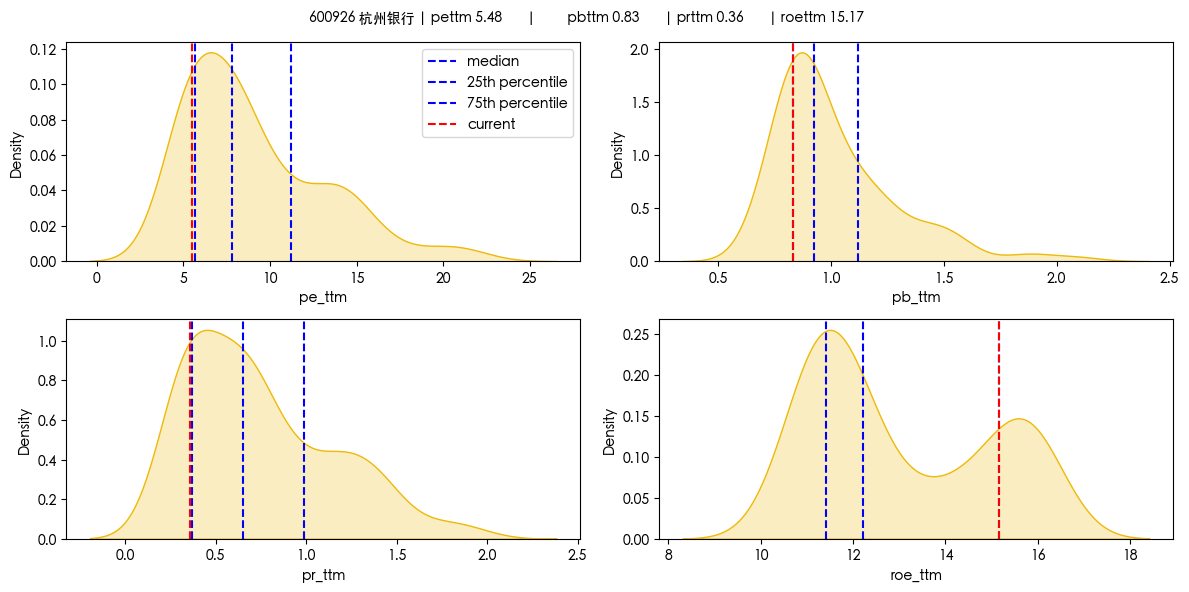

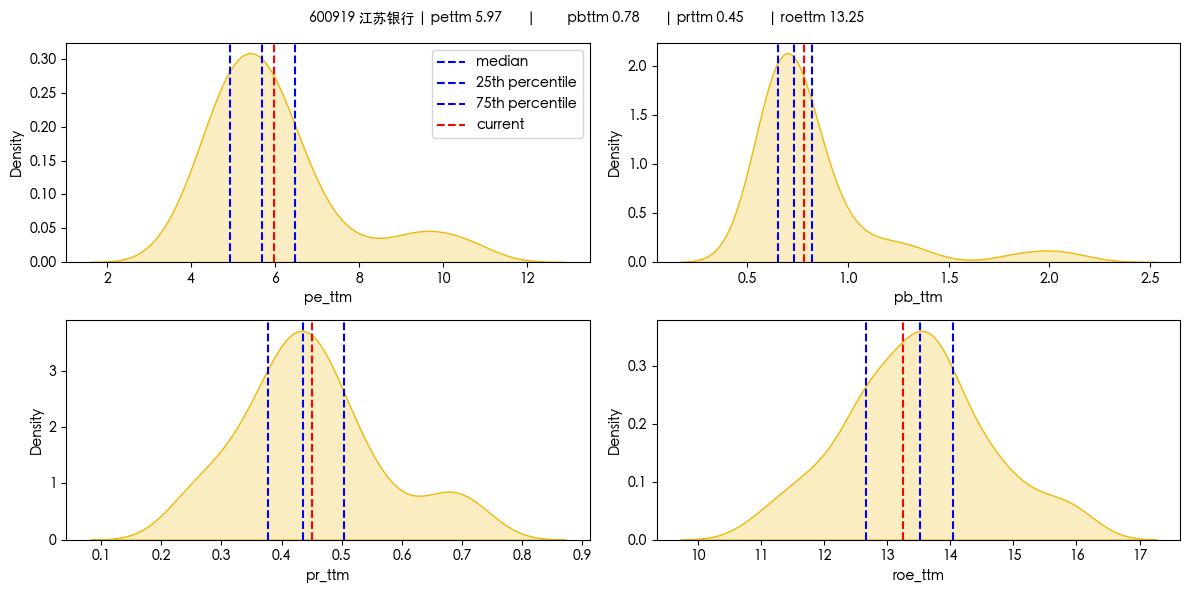

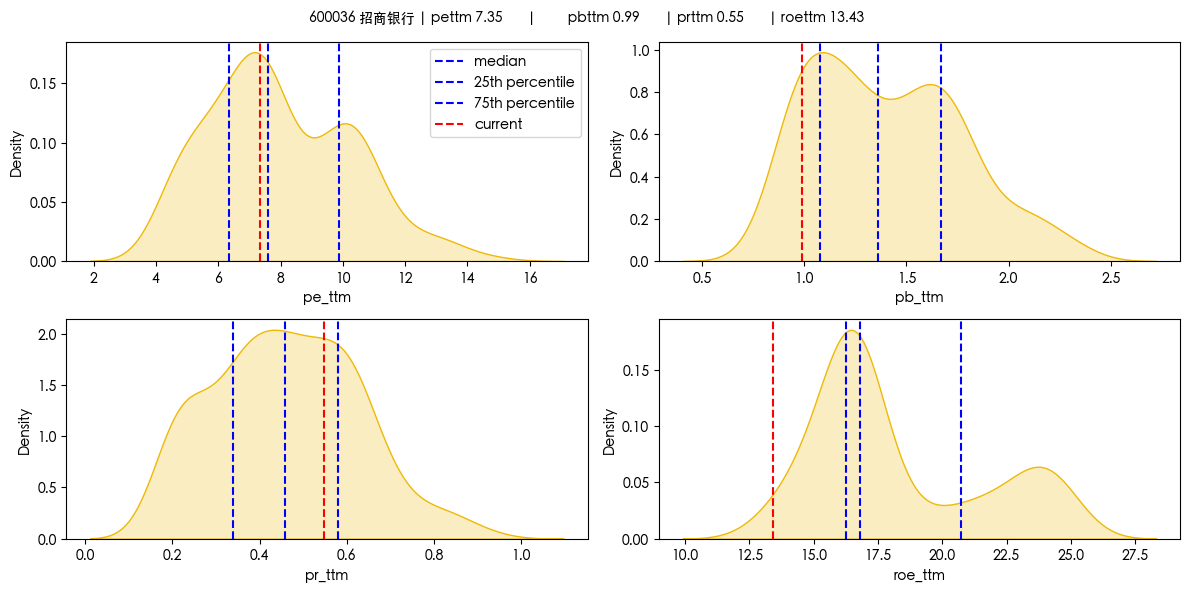

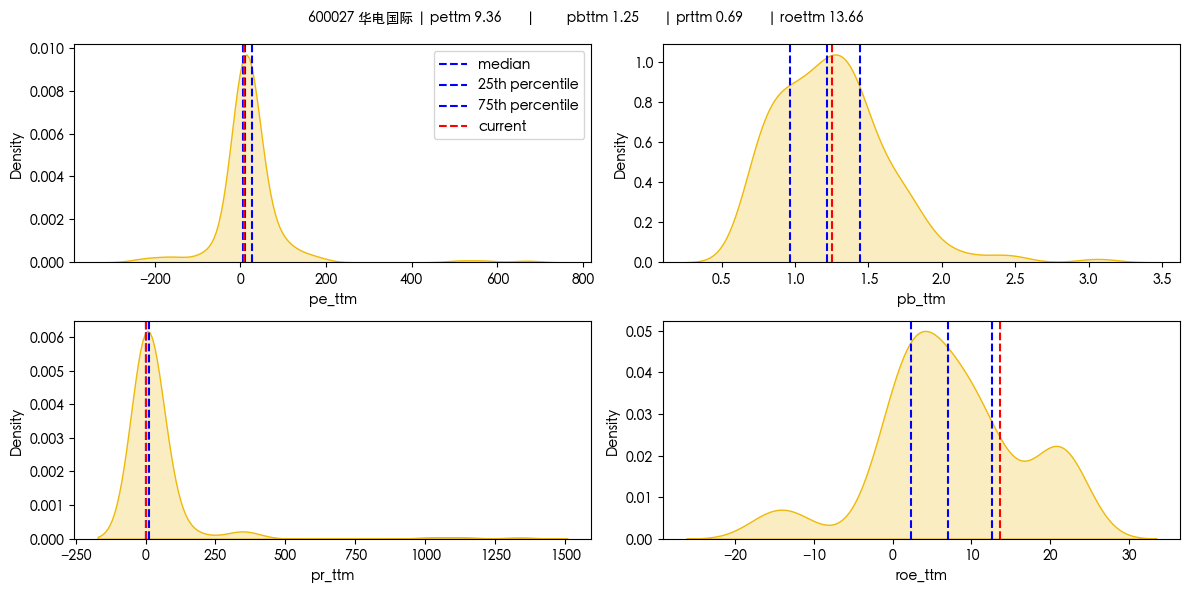

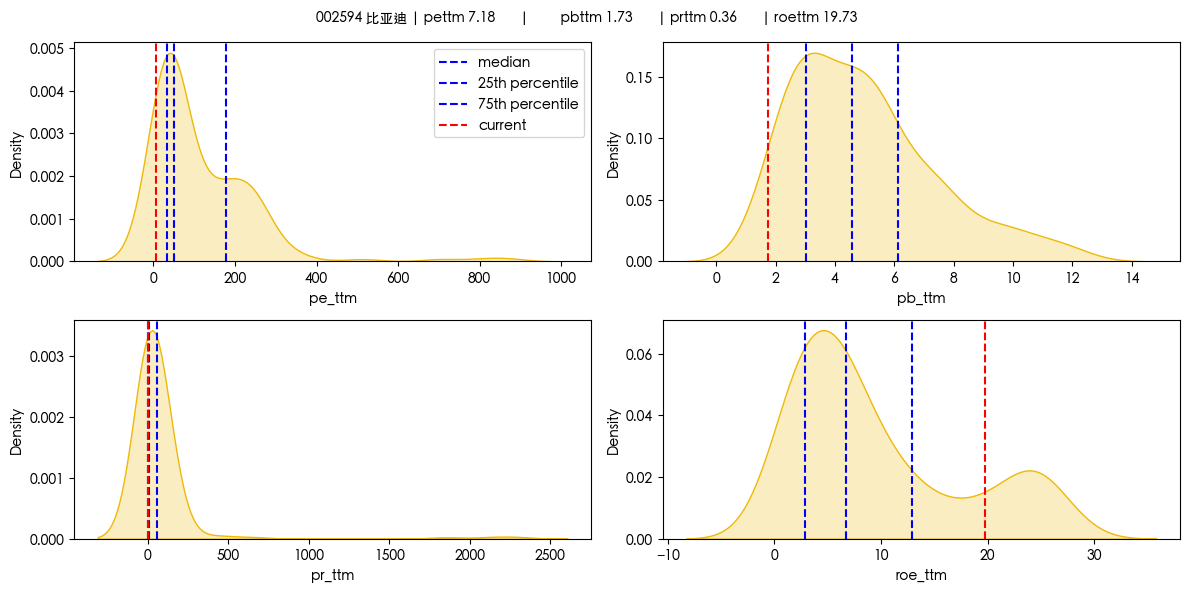

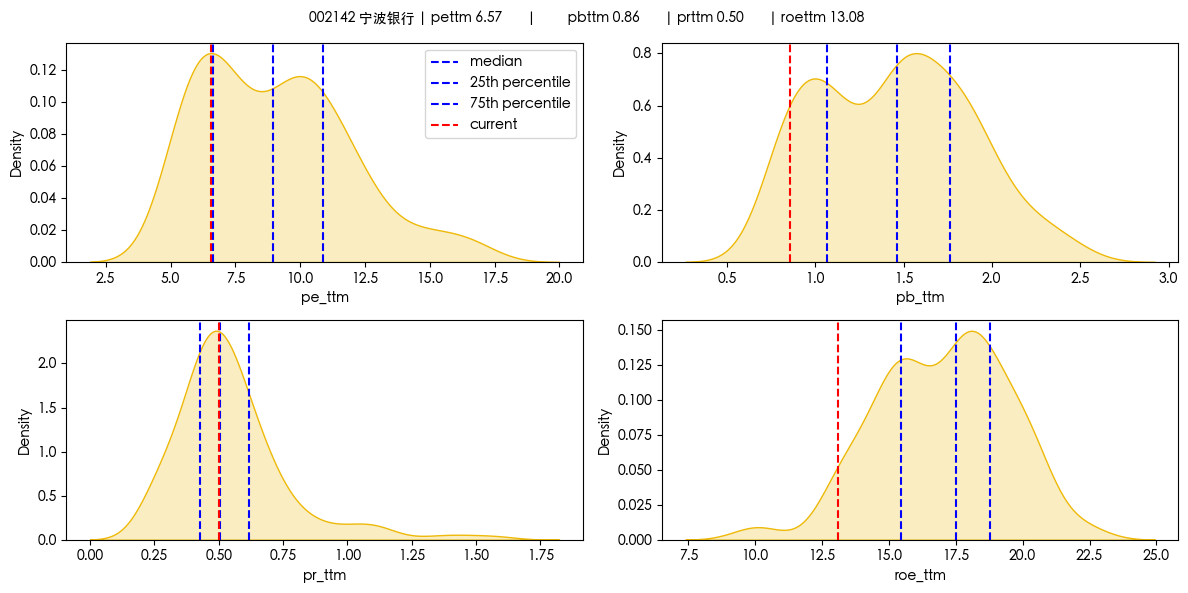

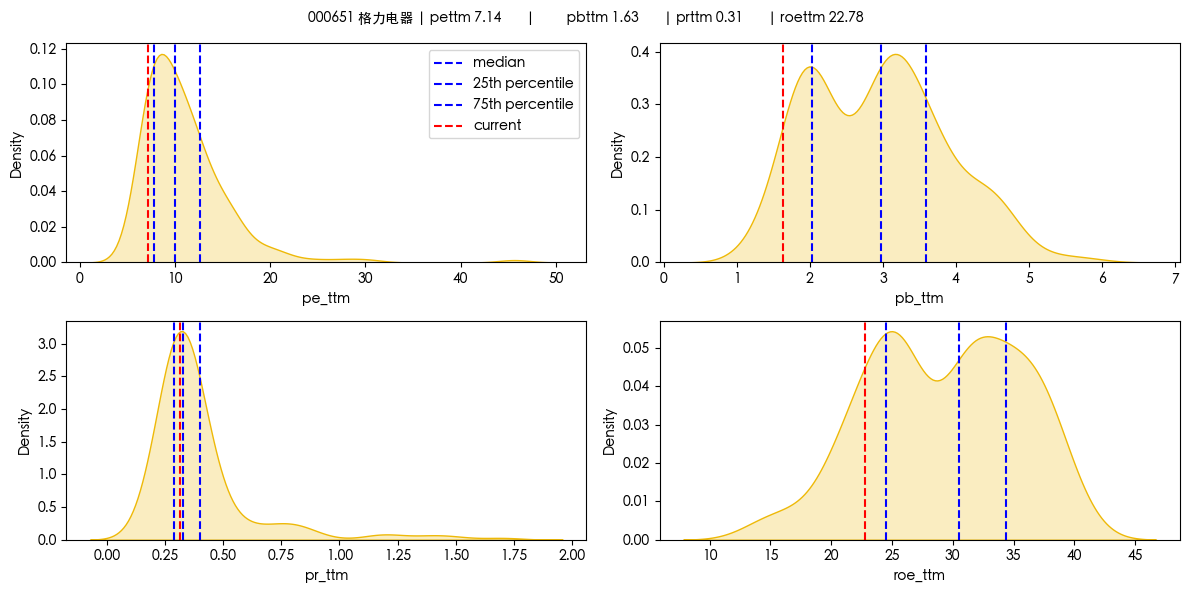

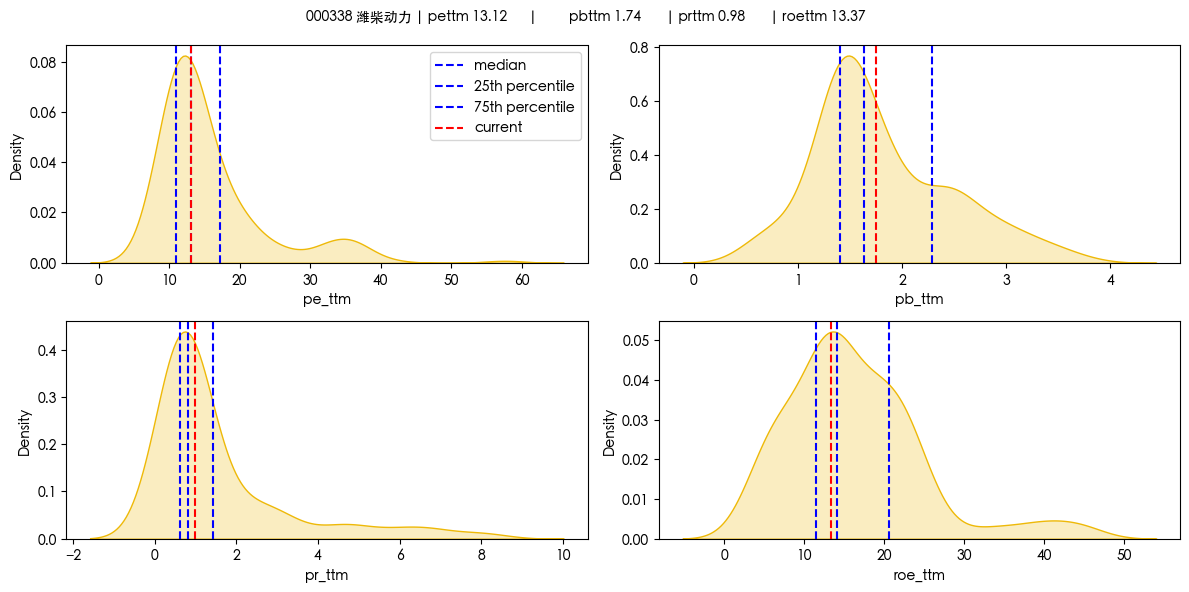

In [100]:
today = pd.to_datetime("today").strftime("%Y%m%d")
ob_stocks = hs_values_filtered.code.tolist()

for stock_code in ob_stocks:
    try: 
        financial_price = pd.read_csv(f"../data/processed/stock-valuation/20251213/stock_valuation_{stock_code}_20251213.csv")
    except Exception: 
        financial_price = pd.read_csv(f"../data/processed/stock-valuation/20251213/stock_valuation_{stock_code}_20251214.csv")

    fig, axes = plt.subplots(2, 2, figsize=(12, 6))
    axes = axes.flatten()

    # pe ttm distribution
    sns.kdeplot(financial_price, x='pe_ttm', fill=True, color="#eeb908", ax=axes[0])
    
    # median pettm
    axes[0].axvline(x=financial_price['pe_ttm'].median(), color='blue', linestyle='--', label='median')
    # 25th percentile
    axes[0].axvline(x=financial_price['pe_ttm'].quantile(0.25), color='blue', linestyle='--', label='25th percentile')
    # 75th percentile
    axes[0].axvline(x=financial_price['pe_ttm'].quantile(0.75), color='blue', linestyle='--', label='75th percentile')
    
    # current pe ttm
    axes[0].axvline(x=financial_price.iloc[-1, -4], color='red', linestyle='--', label='current')
    axes[0].legend()

    # pb ttm distribution
    sns.kdeplot(financial_price, x='pb_ttm', fill=True, color="#eeb908", ax=axes[1])
    
    # median pbttm
    axes[1].axvline(x=financial_price['pb_ttm'].median(), color='blue', linestyle='--')
    # 25th percentile
    axes[1].axvline(x=financial_price['pb_ttm'].quantile(0.25), color='blue', linestyle='--')
    # 75th percentile
    axes[1].axvline(x=financial_price['pb_ttm'].quantile(0.75), color='blue', linestyle='--')
    # current pb ttm
    axes[1].axvline(x=financial_price.iloc[-1, -3], color='red', linestyle='--')

    # pr ttm distribution
    sns.kdeplot(financial_price, x='pr_ttm', fill=True, color="#eeb908", ax=axes[2])
    
    # median prttm
    axes[2].axvline(x=financial_price['pr_ttm'].median(), color='blue', linestyle='--')
    # 25th percentile
    axes[2].axvline(x=financial_price['pr_ttm'].quantile(0.25), color='blue', linestyle='--')
    # 75th percentile
    axes[2].axvline(x=financial_price['pr_ttm'].quantile(0.75), color='blue', linestyle='--')
    # current pr ttm
    axes[2].axvline(x=financial_price.iloc[-1, -2], color='red', linestyle='--')

    # roe ttm distribution
    sns.kdeplot(financial_price, x='roe_ttm', fill=True, color="#eeb908", ax=axes[3])
    
    # median roettm
    axes[3].axvline(x=financial_price['roe_ttm'].median(), color='blue', linestyle='--')
    # 25th percentile
    axes[3].axvline(x=financial_price['roe_ttm'].quantile(0.25), color='blue', linestyle='--')
    # 75th percentile
    axes[3].axvline(x=financial_price['roe_ttm'].quantile(0.75), color='blue', linestyle='--')
    # current roe ttm
    axes[3].axvline(x=financial_price.iloc[-1, -5], color='red', linestyle='--')
    
    stock_names = pd.read_csv("../data/input/stock_names_full.csv")
    stock_name = stock_names[stock_names['code'] == int(stock_code)]['name'].values[0]
    fig.suptitle(f"{stock_code} {stock_name} | pettm {financial_price.iloc[-1, -4]:<10.2f} | \
        pbttm {financial_price.iloc[-1, -3]:<10.2f} | prttm {financial_price.iloc[-1, -2]:<10.2f} | roettm {financial_price.iloc[-1, -5]:<10.2f}", 
        fontsize=10)
    plt.tight_layout()
    # plt.legend()
   
    # save the image
    # craete the img/20251213 folder if it doesn't exist
    if not os.path.exists("../img/20251213"):
        os.makedirs("../img/20251213")
    plt.savefig(f"../img/20251213/pe_pb_pr_roe_distribution_monthly_close_{stock_code}_{today}.png", dpi=300)
    plt.show()

### calculate hongli and honglidibo values

In [95]:
# assuming a total 100 investment
# earning yield = sum(shares * eps) = sum(invest/ price * eps) / 100
hl_values['earning_yield'] = hl_values['weight'] / hl_values['close'] * hl_values['eps_ttm']
# net asset yield = sum(shares * bps) = sum(invest / price * bps) / 100
hl_values['net_asset_yield'] = hl_values['weight'] / hl_values['close'] * hl_values['bps_ttm']

total_investment = hl_values['weight'].sum()
earning_yield = hl_values['earning_yield'].sum() / total_investment
net_asset_yield = hl_values['net_asset_yield'].sum() / total_investment
weited_roe = earning_yield / net_asset_yield

print(f"中证红利：")
print(f"earning yield: {earning_yield:.2f}")
print(f"net asset yield: {net_asset_yield:.2f}")
print(f"weighted roe: {weited_roe:.2f}")

中证红利：
earning yield: 0.09
net asset yield: 1.12
weighted roe: 0.08


In [93]:
# assuming a total 100 investment
# earning yield = sum(shares * eps) = sum(invest/ price * eps) / 100
hldb_values['earning_yield'] = hldb_values['weight'] / hldb_values['close'] * hldb_values['eps_ttm']
# net asset yield = sum(shares * bps) = sum(invest / price * bps) / 100
hldb_values['net_asset_yield'] = hldb_values['weight'] / hldb_values['close'] * hldb_values['bps_ttm']

total_investment = hldb_values['weight'].sum()
earning_yield = hldb_values['earning_yield'].sum() / total_investment
net_asset_yield = hldb_values['net_asset_yield'].sum() / total_investment
weited_roe = earning_yield / net_asset_yield

print(f"红利低波：")
print(f"earning yield: {earning_yield:.2f}")
print(f"net asset yield: {net_asset_yield:.2f}")
print(f"weighted roe: {weited_roe:.2f}")

红利低波：
earning yield: 0.12
net asset yield: 1.22
weighted roe: 0.09
